In [1]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score

# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
pca_df = pd.read_csv('pca_df.csv')
df_subset = pd.read_csv('df_subset.csv')

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

# Model based clustering

## Gaussian Mixture

In [4]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [5]:
# Define the parameter grid
param_grid = {
    'n_components': range(2,11),
}

gaussian_mix_clust = GaussianMixture(random_state=42)
                                     
# Initialize GridSearchCV
grid_search = GridSearchCV(gaussian_mix_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(pca_df)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[CV] END .....................................n_components=2; total time=  23.5s
[CV] END .....................................n_components=4; total time=  23.7s
[CV] END .....................................n_components=2; total time=  24.0s
[CV] END .....................................n_components=5; total time=  24.1s
[CV] END .....................................n_components=5; total time=  24.1s
[CV] END .....................................n_components=4; total time=  24.2s
[CV] END .....................................n_components=3; total time=  24.2s
[CV] END .....................................n_components=3; total time=  24.3s
[CV] END .....................................n_components=6; total time=  22.9s
[CV] END .....................................n_components=6; total time=  23.4s
[CV] END .....................................n_components=7; total time=  23.1s
[CV] END .....................................n_components=7; total time=  23.3s
[CV] END ...................

GridSearchCV(cv=2, estimator=GaussianMixture(random_state=42), n_jobs=-1,
             param_grid={'n_components': range(2, 11)},
             scoring=<function clustering_score at 0x7f777415ede0>, verbose=2)

In [6]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_components': 2}
Best Silhouette Score: 2.1332629830771355


In [7]:
gaussian_mix = GaussianMixture(n_components=2, random_state=42, verbose=1)
gaussian_mix.fit(pca_df)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=2, random_state=42, verbose=1)

In [8]:
with open('results/model_based_opt/gaussian_mix.pickle', 'wb') as f:
    pickle.dump(gaussian_mix, f)

In [8]:
with open('results/model_based_opt/gaussian_mix.pickle', 'rb') as f:
    gaussian_mix = pickle.load(f)

In [9]:
labels = gaussian_mix.predict(pca_df)

In [10]:
len(np.unique(labels))

2

In [11]:
pca_df = pca_df.loc[:,:'PC2']

In [12]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

In [13]:
pca_df.to_csv('results/model_based_opt/csv_labels_cut_raw/gaussian_mix.csv', index = False)

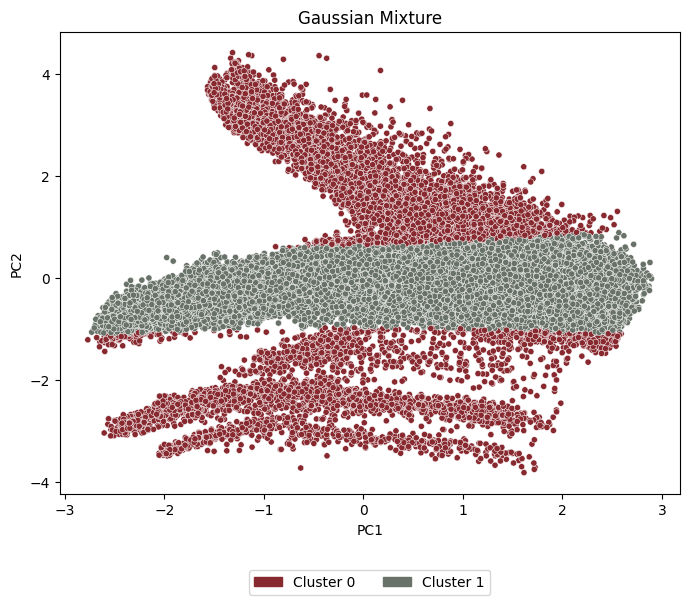

In [14]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [15]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns= 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.208193,-2.610168,11,0
1,-1.582444,-2.590071,11,0
2,-2.160770,-2.562577,11,0
3,-1.116426,-2.224564,11,0
4,-0.945115,-2.166657,11,0


In [16]:
len(most_frequent_clusters.unique())

2

In [17]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.208193,-2.610168,11,0
1,-1.582444,-2.590071,11,0
2,-2.160770,-2.562577,11,0
3,-1.116426,-2.224564,11,0
4,-0.945115,-2.166657,11,0


In [18]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.208193,-2.610168,0
1,12,-1.976314,-3.411550,0
2,13,-1.800464,-0.028575,1
3,14,-1.285991,-0.173655,1
4,15,-2.335222,-0.569351,1
...,...,...,...,...
72,510,-0.089014,2.331186,0
73,511,-0.785829,3.231834,0
74,512,0.379547,0.789382,0
75,513,-1.432399,3.377288,0


In [19]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 52, 58, 72, 73, 74, 75, 76]
Cluster 1: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


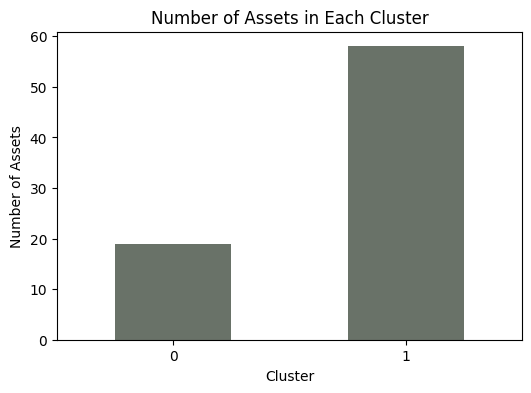

In [20]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [21]:
pca_df.to_csv('results/model_based_opt/labels_most_common/gaussian_mix.csv', index= False)

In [22]:
pca_df = pca_df.loc[:,:'PC2']

## Bayesian GMM

In [23]:
# Define the parameter grid
param_grid = {
    'n_components': range(2,11),
}

bgmm_clust = BayesianGaussianMixture(covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
                                     
# Initialize GridSearchCV
grid_search = GridSearchCV(bgmm_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(pca_df)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END .....................................n_components=2; total time=  20.9s
[CV] END .....................................n_components=2; total time=  21.2s
[CV] END .....................................n_components=3; total time=  24.5s
[CV] END .....................................n_components=3; total time=  25.4s
[CV] END .....................................n_components=4; total time=  26.1s
[CV] END .....................................n_components=4; total time=  26.8s
[CV] END .....................................n_components=5; total time=  31.7s
[CV] END .....................................n_components=5; total time=  31.7s
[CV] END .....................................n_components=6; total time=  39.2s
[CV] END .....................................n_components=6; total time=  39.3s


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV] END .....................................n_components=7; total time= 1.3min
[CV] END .....................................n_components=9; total time= 1.2min
[CV] END .....................................n_components=7; total time= 1.3min
[CV] END .....................................n_components=9; total time= 1.2min
[CV] END .....................................n_components=8; total time= 1.4min
[CV] END .....................................n_components=8; total time= 1.4min


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[CV] END ....................................n_components=10; total time= 1.2min
[CV] END ....................................n_components=10; total time= 1.2min


GridSearchCV(cv=2,
             estimator=BayesianGaussianMixture(max_iter=1000, random_state=42,
                                               tol=1e-06),
             n_jobs=-1, param_grid={'n_components': range(2, 11)},
             scoring=<function clustering_score at 0x7f777415ede0>, verbose=2)

In [27]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_components': 2}
Best Silhouette Score: 2.1534186606987245


In [28]:
# Fitting Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=2, covariance_type='full', max_iter=1000, random_state=42, tol=1e-6)
bgmm.fit(pca_df)

# Predicting clusters for data points
labels = bgmm.predict(pca_df)

In [29]:
with open('results/model_based_opt/bgmm.pickle', 'wb') as f:
    pickle.dump(bgmm, f)

In [30]:
with open('results/model_based_opt/bgmm.pickle', 'rb') as f:
    bgmm = pickle.load(f)

In [31]:
labels = bgmm.predict(pca_df)

In [32]:
pca_df = pca_df.loc[:,:'PC2']

In [33]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

In [34]:
pca_df.to_csv('results/model_based_opt/csv_labels_cut_raw/bgmm.csv', index = False)

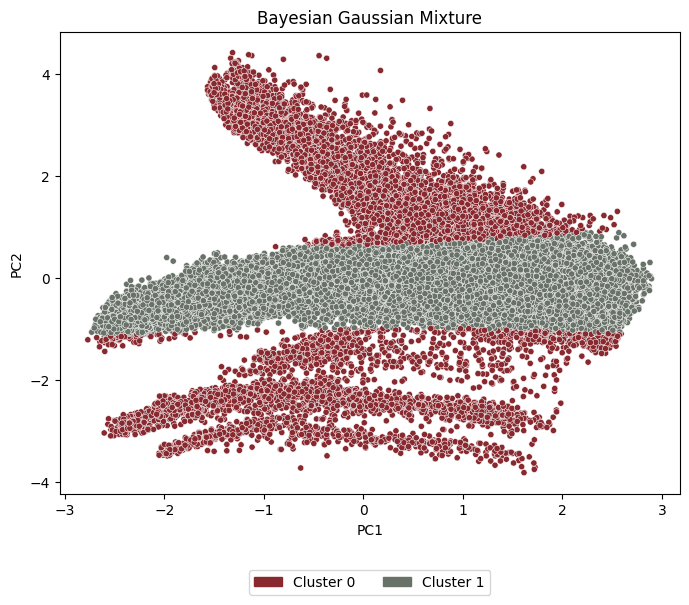

In [35]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Bayesian Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [36]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns = 'cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.208193,-2.610168,11,0
1,-1.582444,-2.590071,11,0
2,-2.160770,-2.562577,11,0
3,-1.116426,-2.224564,11,0
4,-0.945115,-2.166657,11,0


In [37]:
len(most_frequent_clusters.unique())

2

In [38]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.208193,-2.610168,0
1,12,-1.976314,-3.411550,0
2,13,-1.800464,-0.028575,1
3,14,-1.285991,-0.173655,1
4,15,-2.335222,-0.569351,1
...,...,...,...,...
72,510,-0.089014,2.331186,0
73,511,-0.785829,3.231834,0
74,512,0.379547,0.789382,0
75,513,-1.432399,3.377288,0


In [39]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 52, 58, 72, 73, 74, 75, 76]
Cluster 1: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


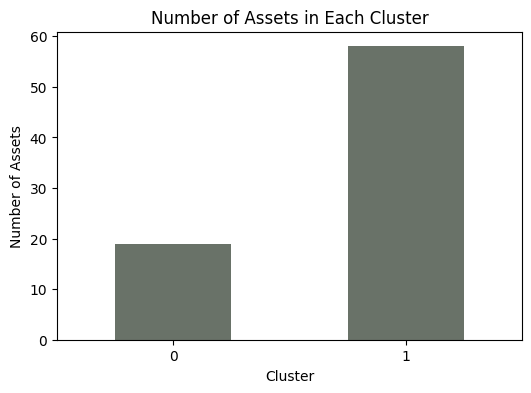

In [40]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [41]:
pca_df.to_csv('results/model_based_opt/labels_most_common/bgmm.csv', index= False)

In [42]:
pca_df = pca_df.loc[:,:'PC2']